**🔹 Import Libraries and Set Hyperparameters**

- Imports the necessary libraries: `pennylane`, `math`, and Pennylane’s version of `numpy`.

- Defines key configuration values:
  - `n_qubits = 4`: Number of qubits used in each quantum circuit.
  - `patch_size = 2`: Each image is divided into 2×2 patches.
  - `layers = 1`: Number of trainable layers in the quantum circuit.
  - `levels = 3`: Number of hierarchical levels (for future multi-layer structure).


In [ ]:
pip install qiskit==1.4.2 tensorflow numpy pandas matplotlib pennylane silence-tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import warnings
tf.keras.backend.set_floatx('float32')
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import pennylane as qml

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


**🔹 Data Loading and Preprocessing**

- Loads the **MNIST** dataset (handwritten digit images).

- **Normalization**: Scales pixel values from **0–255** to **0–1** by dividing by 255.

- Takes one training image (`train_images[0]`) and the first 10 test images (`test_images[0:10]`).

- Converts all image arrays to `float32` type (for compatibility with TensorFlow and PennyLane).

- Displays one training image using **matplotlib** to verify preprocessing.


In [ ]:
# Load MNIST
import numpy as np
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(f"Original x_train shape: {x_train.shape}")
print(f"Original y_train shape: {y_train.shape}")
print(f"Original x_test shape: {x_test.shape}")
print(f"Original y_test shape: {y_test.shape}")

# Filter only digits 0 and 5
train_filter = np.where((y_train == 0) | (y_train == 5))
test_filter = np.where((y_test == 0) | (y_test == 5))

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

print(f"Filtered x_train shape (only 0 & 5): {x_train.shape}")
print(f"Filtered y_train unique labels: {np.unique(y_train)}")
print(f"Filtered x_test shape (only 0 & 5): {x_test.shape}")
print(f"Filtered y_test unique labels: {np.unique(y_test)}")

# Relabel: 0 stays 0, 5 becomes 1
y_train = np.where(y_train == 0, 0, 1)
y_test = np.where(y_test == 0, 0, 1)

# Normalize images and cast to float32
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Select 50 samples of each class (0 and 1) for training
idx_0 = np.where(y_train == 0)[0][:50]
idx_1 = np.where(y_train == 1)[0][:50]
selected_idx = np.concatenate([idx_0, idx_1])

x_train = x_train[selected_idx]
y_train = y_train[selected_idx]

print(f"Balanced x_train shape: {x_train.shape}")
print(f"Balanced y_train distribution: {np.bincount(y_train.astype(int))}")

Original x_train shape: (60000, 28, 28)
Original y_train shape: (60000,)
Original x_test shape: (10000, 28, 28)
Original y_test shape: (10000,)
Filtered x_train shape (only 0 & 5): (11344, 28, 28)
Filtered y_train unique labels: [0 5]
Filtered x_test shape (only 0 & 5): (1872, 28, 28)
Filtered y_test unique labels: [0 5]
Balanced x_train shape: (100, 28, 28)
Balanced y_train distribution: [50 50]


In [ ]:
batch_size = 16 # choose based on your GPU/CPU capacity

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


**🔹 Visualizing the Image**

- Plots the selected training image using `matplotlib`.

- Applies a grayscale colormap (`gray`) for display.

- Displays the digit label as the plot title.


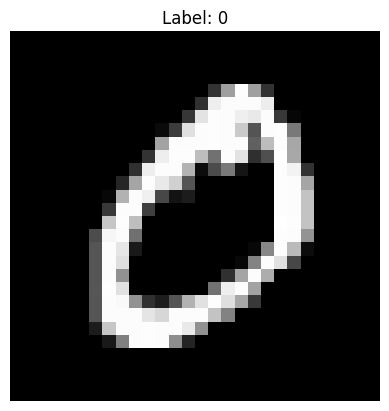

In [ ]:
# Pick an index to visualize
index = 0
# Reshape the image back to 28x28 for plotting
image = x_train[index].reshape(28, 28)
# Plot the image
plt.imshow(image, cmap='gray')
plt.title(f"Label: {int(y_train[index])}")
plt.axis('off')
plt.show()

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import math

In [ ]:
n_qubits = 4
patch_size = 2
layers = 1
levels=3


**🔹 Quantum Circuit Definition**

- A quantum circuit is built using PennyLane and integrated with TensorFlow.

- The circuit structure:
  - **Feature map**: Applies `RY` rotations using input data to encode classical information.
  - **Variational layer**:
    - Applies trainable `RY` rotations for each qubit.
    - Adds entanglement between neighboring qubits using `CNOT` gates.
  - **Measurement**: Measures the expectation value of `PauliZ` on each qubit.

- The circuit returns a list of `n_qubits` expectation values for further use.


In [ ]:
dev = qml.device('default.qubit', wires=n_qubits)
@qml.qnode(dev, interface="tf")
@tf.autograph.experimental.do_not_convert
def quantum_circuit(inputs, weights):
    for i in range(n_qubits):  # feature map
        qml.RY(np.pi * inputs[i], wires=i)

    for l in range(layers):
        for i in range(n_qubits):
            qml.RY(weights[l][i], wires=i)
        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i + 1) % n_qubits])

    # Return the list of expectation values directly — no tf.stack
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

**🔹 Image Patch Extraction**

- Defines `extract_patches()` function to divide the 28×28 image into non-overlapping patches.

- Each patch is of size `patch_size × patch_size` (2×2).

- Each 2×2 patch is flattened to a vector and stacked into a tensor.

- This step is essential to map image patches to the fixed input size required by quantum circuits.


In [ ]:
def extract_patches_batch(img_batch, patch_size):
    # img_batch shape: (batch_size, H, W)
    batch_size = img_batch.shape[0]
    patches_all = []

    for b in range(batch_size):
        patches = []
        img = img_batch[b]
        for i in range(0, img.shape[0], patch_size):
            for j in range(0, img.shape[1], patch_size):
                patch = img[i:i+patch_size, j:j+patch_size]
                if patch.shape == (patch_size, patch_size):
                    patches.append(tf.reshape(patch, [-1]))
        patches_all.append(tf.stack(patches))  # Shape (num_patches, patch_dim)

    return tf.stack(patches_all)  # Shape: (batch_size, num_patches, patch_dim)


**🔹 Initialize Trainable Quantum Weights**

- Random seeds are set for reproducibility.

- Three sets of weights (`weights_l1`, `weights_l2`, `weights_l3`) are initialized for three levels.

- Each set has shape `(layers, n_qubits)` which matches the number of trainable gates per layer and per qubit.

- Currently, only `weights_l1` is actively used for building the quantum layer.


In [ ]:
#all_weights = []
tf.random.set_seed(42)
np.random.seed(42)

weights_l1 = tf.Variable(tf.random.normal((layers, n_qubits),stddev=0.1),trainable=True)# no of weights is (layers * n_qubits)
weights_l2 = tf.Variable(tf.random.normal((layers, n_qubits),stddev=0.1),trainable=True)# no of weights is (layers * n_qubits)
weights_l3 = tf.Variable(tf.random.normal((layers, n_qubits),stddev=0.1),trainable=True)# no of weights is (layers * n_qubits)
print("weights in level 1 shape:", weights_l1.shape)

weights in level 1 shape: (1, 4)


**🔹 Classical Neural Network Model**

- A simple classical neural network is defined using `tf.keras.Sequential`.

- Takes an input of shape `(9,)` – expected to be quantum outputs or processed features.

- Applies a `Dense` layer with 10 output nodes using `softmax` activation.

- Designed to classify digits (0–9) based on quantum-derived features.


In [ ]:
# Classical model (trainable)
classical_model = tf.keras.Sequential([
    tf.keras.Input(shape=(9,)),
    tf.keras.layers.Dense(2, activation='softmax')
])
print("combining with classical model")

# this is for classical parameteres defined for the classical part

combining with classical model


**🔹 Optimizer and Loss Function**

- Defines the **Adam optimizer** with a learning rate of 0.01.

- Uses **Sparse Categorical Crossentropy** as the loss function — suitable for multi-class classification where labels are integers (e.g., MNIST digits 0 and 5).


In [ ]:
# Optimizer and loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

concatenating quantum part together

**🔹 Forward Pass (Quantum + Classical Integration)**

- **Level 1**:
  - Extracts 2×2 patches from the 28×28 image → gets 196 patches.
  - Each patch is processed by the quantum circuit with `weights_l1`.
  - Output from 4 qubits is averaged into a single value per patch.
  - All 196 values are reshaped back to a 14×14 matrix (like an intermediate feature map).

- **Level 2**:
  - The 14×14 output is again patched (2×2) → results in 49 patches.
  - Each patch is passed through the quantum circuit with `weights_l2`.
  - Again, outputs are averaged and reshaped into a 7×7 image.

- **Level 3**:
  - The 7×7 output is patched into 9 patches.
  - These are passed through the quantum circuit using `weights_l3`.
  - Outputs are reduced to 9 values → final feature vector of shape (1, 9).

- The 9-dimensional quantum-processed feature vector is fed into the **classical model** for classification.


In [ ]:
def forward_batch(x_imgs):
    batch_size = x_imgs.shape[0]

    # First layer patches: (batch_size, num_patches, patch_dim)
    patches1_batch = extract_patches_batch(x_imgs, patch_size)  # e.g., (batch, 196, 4)
    print("patches1_batch shape:", patches1_batch.shape)

    q_outputs1_batch = []
    for b in range(batch_size):
        q_outputs1 = []
        for i in range(patches1_batch.shape[1]):  # num_patches per image
            patch = patches1_batch[b, i]
            q_out = quantum_circuit(patch, weights_l1)
            q_out = tf.stack(q_out) if isinstance(q_out, (list, tuple)) else q_out
            q_out = tf.cast(tf.math.real(q_out), tf.float32)
            q_outputs1.append(tf.reduce_mean(q_out))
        q_outputs1 = tf.stack(q_outputs1)
        q_outputs1_reshaped = tf.reshape(q_outputs1, (14, 14))
        q_outputs1_batch.append(q_outputs1_reshaped)

    q_outputs1_batch = tf.stack(q_outputs1_batch)  # (batch_size, 14, 14)
    print("q_outputs1_batch shape:", q_outputs1_batch.shape)

    # Second layer patches
    patches2_batch = extract_patches_batch(q_outputs1_batch, patch_size)  # (batch_size, 49, 4)
    print("patches2_batch shape:", patches2_batch.shape)

    q_outputs2_batch = []
    for b in range(batch_size):
        q_outputs2 = []
        for i in range(patches2_batch.shape[1]):
            patch = patches2_batch[b, i]
            q_out = quantum_circuit(patch, weights_l2)
            q_out = tf.stack(q_out) if isinstance(q_out, (list, tuple)) else q_out
            q_out = tf.cast(tf.math.real(q_out), tf.float32)
            q_outputs2.append(tf.reduce_mean(q_out))
        q_outputs2 = tf.stack(q_outputs2)
        q_outputs2_reshaped = tf.reshape(q_outputs2, (7, 7))
        q_outputs2_batch.append(q_outputs2_reshaped)

    q_outputs2_batch = tf.stack(q_outputs2_batch)  # (batch_size, 7, 7)
    print("q_outputs2_batch shape:", q_outputs2_batch.shape)

    # Third layer patches
    patches3_batch = extract_patches_batch(q_outputs2_batch, patch_size)  # (batch_size, 9, 4)
    print("patches3_batch shape:", patches3_batch.shape)

    q_outputs3_batch = []
    for b in range(batch_size):
        q_outputs3 = []
        for i in range(patches3_batch.shape[1]):
            patch = patches3_batch[b, i]
            q_out = quantum_circuit(patch, weights_l3)
            q_out = tf.stack(q_out) if isinstance(q_out, (list, tuple)) else q_out
            q_out = tf.cast(tf.math.real(q_out), tf.float32)
            q_outputs3.append(tf.reduce_mean(q_out))
        q_outputs3 = tf.stack(q_outputs3)
        q_outputs3_reshaped = tf.reshape(q_outputs3, (1, -1))  # (1, 9)
        q_outputs3_batch.append(q_outputs3_reshaped)

    q_outputs3_batch = tf.concat(q_outputs3_batch, axis=0)  # (batch_size, 9)
    print("q_outputs3_batch shape:", q_outputs3_batch.shape)

    # Pass batch through classical model
    logits = classical_model(q_outputs3_batch)  # (batch_size, num_classes)
    print("logits shape:", logits.shape)

    return logits


**🔹 Training Step with Gradient Tape**

- Wraps the forward pass using `tf.GradientTape()` to compute gradients.

- Reshapes the label to match the model’s output.

- Computes the loss using the predefined loss function.

- Collects **trainable variables**: `weights_l1`, `weights_l2`, and classical model weights.

- Calculates gradients and applies them using the Adam optimizer.

- Returns both the loss and model predictions.


In [ ]:
@tf.function
def train_step_batch(x_imgs, y_labels):
    with tf.GradientTape() as tape:
        predictions = forward_batch(x_imgs)  # (batch_size, num_classes)
        loss = loss_fn(y_labels, predictions)
        tf.print("Loss:", loss)

    trainable_vars = [weights_l1, weights_l2, weights_l3] + classical_model.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    optimizer.apply_gradients(zip(gradients, trainable_vars))

    return loss, predictions


**🔹 Training Loop (Single Image, 20 Epochs)**

- Runs for 20 epochs on a single image and label.

- In each epoch:
  - Performs forward + backward pass using `train_step()`.
  - Calculates and prints loss and accuracy.
  - Logs detailed output:
    - Prediction shape
    - Prediction values
    - Ground truth label
    - Final predicted class

- This loop helps track how the model evolves while training on a very small input set.


In [ ]:
epochs = 20

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for batch_images, batch_labels in train_dataset:
        loss, predictions = train_step_batch(batch_images, batch_labels)
    print(f"Epoch {epoch + 1} completed")


    # print(f"Epoch {epoch+1:2d}/{epochs} | Loss: {loss.numpy():.6f} | Accuracy: {acc.numpy()[0]:.4f}")
    # print(f"  Detailed info at epoch {epoch+1}:")
    # print(f"    Predictions shape: {predictions.shape}")
    # print(f"    Predictions: {predictions.numpy().flatten()}")
    # print(f"    True label: {label}")
    # print(f"    Predicted class: {tf.argmax(predictions, axis=1).numpy()[0]}")
    # print()

Epoch 1/20
patches1_batch shape: (16, 196, 4)
q_outputs1_batch shape: (16, 14, 14)
patches2_batch shape: (16, 49, 4)
q_outputs2_batch shape: (16, 7, 7)
patches3_batch shape: (16, 9, 4)
q_outputs3_batch shape: (16, 9)
logits shape: (16, 2)


In [ ]:
# # Testing function
# @tf.function
# def test_step(x_img, y_label):
#     predictions = forward(x_img)  # shape: (1, 10)
#     loss = loss_fn(tf.reshape(y_label, (1,)), predictions)
#     predicted_class = tf.argmax(predictions, axis=1)[0]
#     return loss, predictions, predicted_class

# # Test on full test set
# def evaluate_model(x_test, y_test, num_samples=None):
#     """
#     Evaluate the model on test data

#     Args:
#         x_test: Test images (tensor with shape like (10, 28, 28))
#         y_test: Test labels (tensor with shape like (10,))
#         num_samples: Number of samples to test (None for all)
#     """
#     if num_samples is None:
#         num_samples = x_test.shape[0]

#     total_loss = 0.0
#     correct_predictions = 0
#     all_predictions = []
#     all_true_labels = []

#     print(f"Testing on {num_samples} samples...")
#     print("-" * 50)

#     for i in range(num_samples):
#         test_img = x_test[i]  # Shape: (28, 28)
#         test_label = y_test[i]

#         # Test the model
#         loss, predictions, predicted_class = test_step(test_img, tf.constant(test_label))

#         # Accumulate metrics
#         total_loss += loss.numpy()
#         is_correct = (predicted_class.numpy() == test_label)
#         if is_correct:
#             correct_predictions += 1

#         all_predictions.append(predicted_class.numpy())
#         all_true_labels.append(test_label)

#         # Print progress every 5 samples (since we only have 10)
#         if (i + 1) % 5 == 0 or i == 0:
#             print(f"Sample {i+1:2d} | True: {test_label} | Pred: {predicted_class.numpy()} | "
#                   f"Correct: {'✓' if is_correct else '✗'} | Loss: {loss.numpy():.4f}")

#     # Calculate final metrics
#     avg_loss = total_loss / num_samples
#     accuracy = correct_predictions / num_samples

#     print("-" * 50)
#     print(f"FINAL RESULTS:")
#     print(f"Test Accuracy: {accuracy:.4f} ({correct_predictions}/{num_samples})")
#     print(f"Average Loss: {avg_loss:.6f}")
#     print("-" * 50)

#     return accuracy, avg_loss, all_predictions, all_true_labels

# # Example usage - test on your 10 samples
# print("Testing model performance...")
# test_accuracy, test_loss, predictions, true_labels = evaluate_model(test_images, test_labels)

# # Detailed analysis
# def analyze_results(predictions, true_labels):
#     """Analyze prediction results in detail"""
#     from collections import Counter

#     # Class-wise accuracy
#     class_correct = Counter()
#     class_total = Counter()

#     for pred, true in zip(predictions, true_labels):
#         class_total[true] += 1
#         if pred == true:
#             class_correct[true] += 1

#     print("\nClass-wise Accuracy:")
#     print("-" * 30)
#     for class_id in sorted(class_total.keys()):
#         acc = class_correct[class_id] / class_total[class_id] if class_total[class_id] > 0 else 0
#         print(f"Class {class_id}: {acc:.4f} ({class_correct[class_id]}/{class_total[class_id]})")

#     # Confusion matrix (simplified)
#     print(f"\nMost confused classes:")
#     errors = [(true, pred) for pred, true in zip(predictions, true_labels) if pred != true]
#     error_counts = Counter(errors)
#     for (true, pred), count in error_counts.most_common(5):
#         print(f"True: {true} → Predicted: {pred} (happened {count} times)")

# # Run detailed analysis
# analyze_results(predictions, true_labels)